<a href="https://colab.research.google.com/github/OUAALOUHOUM/Deep-learning-project/blob/main/UDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* L'apprentissage profond ou apprentissage en profondeur (en anglais : deep learning, deep structured learning, hierarchical learning) est un sous-domaine de l’intelligence artificielle qui utilise des réseaux neuronaux pour résoudre des tâches complexes grâce à des architectures articulées de différentes transformations non linéaires. Ces techniques ont permis des progrès importants et rapides dans les domaines de l'analyse du signal sonore ou visuel et notamment de la reconnaissance faciale, de la reconnaissance vocale, de la vision par ordinateur, du traitement automatisé du langage. .

* Les algorithmes d'apprentissage profond s’opposent aux algorithmes d’apprentissage peu profonds du fait du nombre de transformations réalisées sur les données entre la couche d’entrée et la couche de sortie, où une transformation correspond à une unité de traitement définie par des poids et des seuils.

En d’autres termes, l'algorithme apprend à partir d’exemples de données afin d’être en mesure de produire des résultats précis lorsqu’on lui présente de nouvelles données.

* D'ailleurs, une de ses faiblesses mis à part son temps d'exécution est qu'elle requiert beaucoup de données étiquettées ou labélisées pour bien marcher.

* Pour cette dernière, nous avons l'apprentissage semi-supervised semi supervised learning



Here is an example of how to implement unsupervised data augmentation (UDA) in Keras:

* First, import the necessary libraries:
javascript

In [ ]:
import numpy as np 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


* Load the dataset and split it into labeled and unlabeled data:

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000, 28,28,1)

In [ ]:
ind2=[]
for i in range(10):
  j=np.where(y_train==i)[0][:10]
  ind2.append(j)
index=np.array(ind2).reshape(1,100)[0]
y_train2=y_train[index]

<Axes: ylabel='Count'>

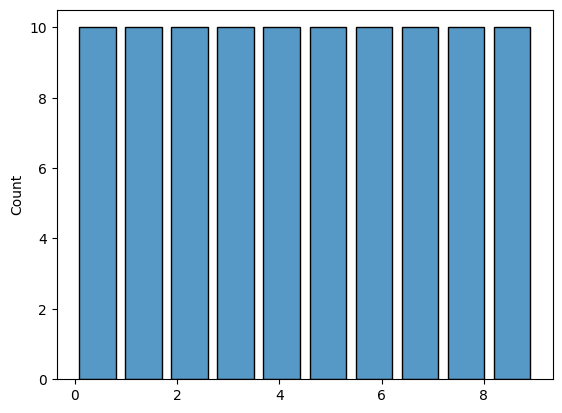

In [ ]:
sns.histplot(data=y_train2,shrink=.8,bins=10)

In [ ]:
labeled_data = (x_train[index], y_train[index])
unlabeled_data = np.delete(x_train,index,axis=0)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
unlabeled_data.shape

(59900, 28, 28, 1)

* Create an image data generator for data augmentation:

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest')


* Define a function to apply data augmentation to the unlabeled data:

In [ ]:
def augment_data(images):
    aug_images = np.zeros_like(images)
    for i in range(images.shape[0]):
        aug_images[i] = datagen.random_transform(images[i])
    return aug_images


* Define the model architecture:

In [ ]:
input_shape=(28,28,1)
num_classes = 10
# Create the UDA model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


* Define the loss function and optimizer:

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()


* Define the training loop:
In this example, we first load the CIFAR-10 dataset and split it into labeled and unlabeled data. We then create an image data generator

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
labeled_batch_size = 32
unlabeled_batch_size = 128
num_epochs = 5

for epoch in range(num_epochs):
    # Train on labeled data
    labeled_dataset = tf.data.Dataset.from_tensor_slices(labeled_data)
    labeled_dataset = labeled_dataset.shuffle(len(labeled_data[0]))
    labeled_dataset = labeled_dataset.batch(labeled_batch_size)
    for x, y in labeled_dataset:
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            #print(y)
            #print(logits)
            loss = loss_fn(y, logits)
            #print(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    # Train on unlabeled data
    unlabeled_dataset = tf.data.Dataset.from_tensor_slices(unlabeled_data)
    unlabeled_dataset = unlabeled_dataset.shuffle(len(unlabeled_data))
    unlabeled_dataset = unlabeled_dataset.batch(unlabeled_batch_size)
    for x in unlabeled_dataset:
        x_aug = augment_data(x)
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            logits_aug = model(x_aug, training=True)
            # print(logits_aug)
            # model.predict

            loss = (loss_fn(np.argmax(logits, axis=-1),logits_aug) +
                    loss_fn(np.argmax(logits_aug,axis=-1), logits))
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))


In [ ]:
model.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
Y_train = convert_to_one_hot(y_train, 10).T
Y_test = convert_to_one_hot(y_test, 10).T

In [ ]:
history = model.fit(x_train[index], Y_train[index],validation_data=(x_test,Y_test),epochs = 10, batch_size = 10)

Epoch 1/10
10/10 [==============================] - 7s 611ms/step - loss: 48.4044 - accuracy: 0.1300 - val_loss: 2.7504 - val_accuracy: 0.1939
Epoch 2/10
10/10 [==============================] - 5s 594ms/step - loss: 2.1803 - accuracy: 0.2300 - val_loss: 1.8497 - val_accuracy: 0.3249
Epoch 3/10
10/10 [==============================] - 4s 477ms/step - loss: 1.5053 - accuracy: 0.3500 - val_loss: 1.5792 - val_accuracy: 0.4211
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 1.2350 - accuracy: 0.5300 - val_loss: 1.4677 - val_accuracy: 0.4392
Epoch 5/10
10/10 [==============================] - 5s 584ms/step - loss: 0.8235 - accuracy: 0.6600 - val_loss: 1.2801 - val_accuracy: 0.5741
Epoch 6/10
10/10 [==============================] - 6s 619ms/step - loss: 0.4842 - accuracy: 0.9000 - val_loss: 1.0899 - val_accuracy: 0.6763
Epoch 7/10
10/10 [==============================] - 4s 475ms/step - loss: 0.2531 - accuracy: 0.9300 - val_loss: 1.1858 - val_accuracy: 0.6821
Epoch 8

In [ ]:
model.save()

In [ ]:
model.evaluate(x_test,Y_test)

313/313 [==============================] - 5s 14ms/step - loss: 1.1490 - accuracy: 0.7305


[1.1490060091018677, 0.7304999828338623]

In [ ]:
input_shape=(28,28,1)
num_classes = 10
# Create the UDA model
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history2 = model1.fit(x_train[index], Y_train[index],validation_data=(x_test,Y_test),epochs = 10, batch_size = 10)

Epoch 1/10
10/10 [==============================] - 6s 605ms/step - loss: 39.1870 - accuracy: 0.1800 - val_loss: 19.3971 - val_accuracy: 0.2674
Epoch 2/10
10/10 [==============================] - 5s 597ms/step - loss: 5.8558 - accuracy: 0.4800 - val_loss: 4.9978 - val_accuracy: 0.4821
Epoch 3/10
10/10 [==============================] - 5s 583ms/step - loss: 1.4390 - accuracy: 0.8000 - val_loss: 2.8090 - val_accuracy: 0.6070
Epoch 4/10
10/10 [==============================] - 5s 585ms/step - loss: 0.3925 - accuracy: 0.9000 - val_loss: 2.7395 - val_accuracy: 0.6203
Epoch 5/10
10/10 [==============================] - 5s 595ms/step - loss: 0.0359 - accuracy: 0.9900 - val_loss: 2.8394 - val_accuracy: 0.6081
Epoch 6/10
10/10 [==============================] - 4s 489ms/step - loss: 0.0435 - accuracy: 0.9800 - val_loss: 2.1615 - val_accuracy: 0.6623
Epoch 7/10
10/10 [==============================] - 5s 604ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 2.2338 - val_accuracy: 0.6563
Epoc

In [ ]:
model1.evaluate(x_test,Y_test)

313/313 [==============================] - 4s 12ms/step - loss: 2.0696 - accuracy: 0.6839


[2.0696141719818115, 0.683899998664856]

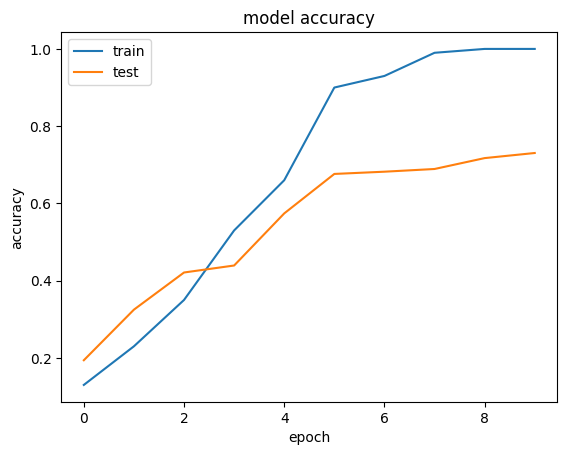

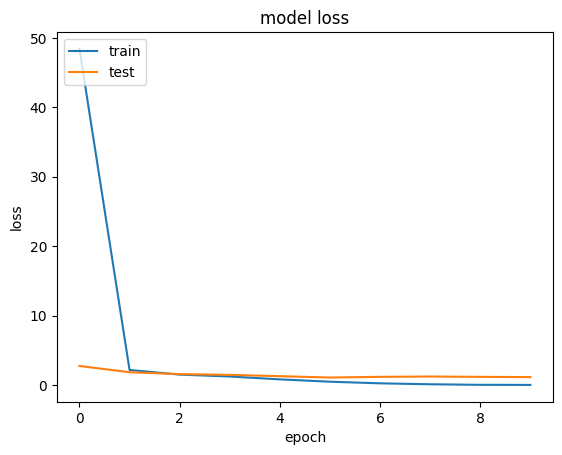

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

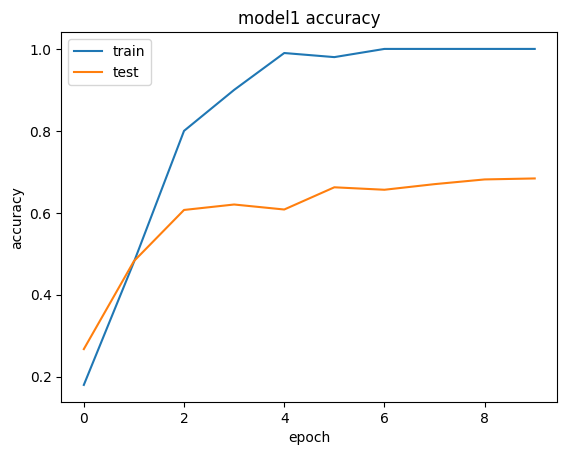

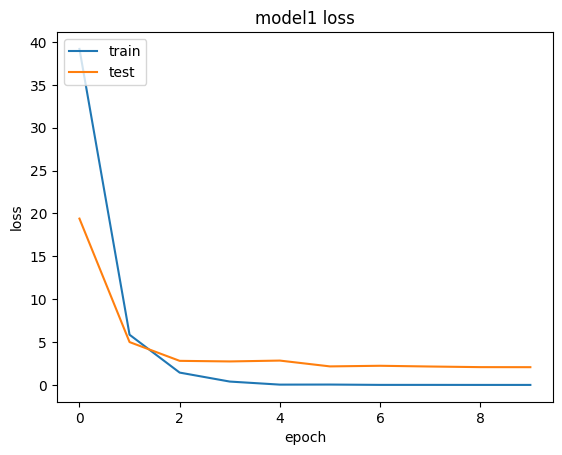

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model1.save("model1.h5")

In [ ]:
model.save("model.h5")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10,10))
x_t=augment_data(x_train[:25])
print(x_t.shape,x_train.shape)


(25, 28, 28, 1) (60000, 28, 28, 1)


<Figure size 1000x1000 with 0 Axes>

In [ ]:
class_names =['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

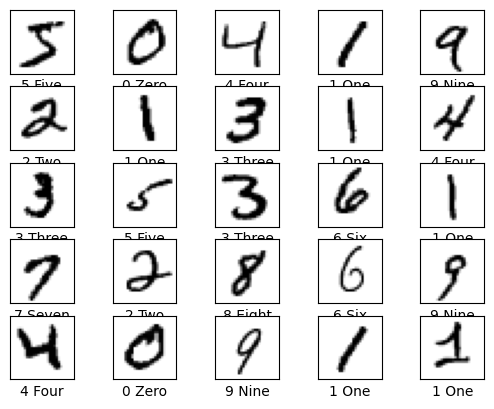

In [ ]:
for i in range(25): # 25 images
  plt.subplot(5,5,i+1) # matrix of 5 X 5 array
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)
  
  plt.xlabel("%s %s" % (y_train[i], class_names[y_train[i]])) # Assigning name to each image
plt.show()

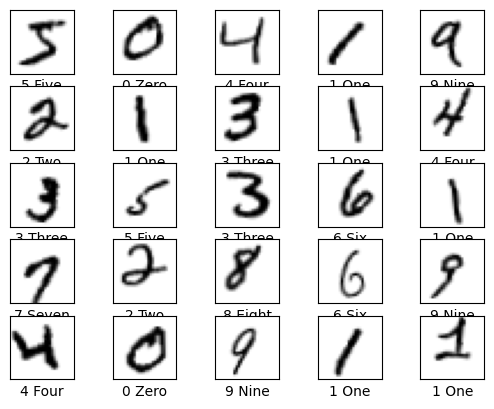

In [ ]:
for i in range(25): # 25 images
  plt.subplot(5,5,i+1) # matrix of 5 X 5 array
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_t[i], cmap=plt.cm.binary)
  
  plt.xlabel("%s %s" % (y_train[i], class_names[y_train[i]])) # Assigning name to each image
plt.show()

In [ ]:
import wide_resnet 

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.layers import Flatten
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler

import math
weight_decay=1e-4
def conv3x3(img, filters):
    #x = BatchNormalization(momentum=0.9, epsilon=1e-5)(img)
    x = Activation('relu')(BatchNormalization(momentum=0.9, epsilon=1e-5)(img))
    x = Conv2D(filters, kernel_size=(3,3), padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(weight_decay))(x)
    return x

def identity(img, filters, kfold=2):
    shortcut = img

    x = conv3x3(img, kfold*filters)
    x = conv3x3(x, kfold*filters)
    x = Add()( [x, shortcut])

    return x

def projection_block(img, filters, kfold=2, stride=(2,2)):
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(img)
    x = Activation('relu')(x)
    
    shortcut = x
    
    x = Conv2D(kfold*filters, kernel_size=(3,3), strides=stride, padding='same',
                kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = conv3x3(x, kfold*filters)

    shortcut = Conv2D(kfold*filters, kernel_size=(1,1), strides=stride, padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(shortcut)
    x = Add()( [x, shortcut])

    return x

def wrn(img, filters, stacks):
    x = Conv2D(filters[0], kernel_size=(3,3), strides=(1,1), padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(weight_decay))(img)

    x = projection_block(x, filters[0], kfold=8, stride=(1,1))
    for i in range(1, stacks):
        x = identity(x, filters[0], kfold=8)
    
    x = projection_block(x, filters[1], kfold=8, stride=(2,2))
    for i in range(1, stacks):
        x = identity(x, filters[1], kfold=8)

    x = projection_block(x, filters[2], kfold=8, stride=(2,2))
    for i in range(1, stacks):
        x = identity(x, filters[2], kfold=8)

    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((5,5))(x)
    x = Flatten()(x)
    x = Dense(num_classes,activation='softmax',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(weight_decay))(x)

    return x

    

In [ ]:
filters = [16,32,64]
stacks  = 2
img_input   = Input(shape=(28,28,1))
output      = wrn(img_input, filters=filters, stacks=stacks)

wide_resnet = Model(img_input, output)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
labeled_batch_size = 32
unlabeled_batch_size = 128
num_epochs = 5

for epoch in range(num_epochs):
    # Train on labeled data
    labeled_dataset = tf.data.Dataset.from_tensor_slices(labeled_data)
    labeled_dataset = labeled_dataset.shuffle(len(labeled_data[0]))
    labeled_dataset = labeled_dataset.batch(labeled_batch_size)
    for x, y in labeled_dataset:
        with tf.GradientTape() as tape:
            logits = wide_resnet(x, training=True)
            #print(y)
            #print(logits)
            loss = loss_fn(y, logits)
            #print(loss)
        grads = tape.gradient(loss, wide_resnet.trainable_weights)
        optimizer.apply_gradients(zip(grads, wide_resnet.trainable_weights))
    
    # Train on unlabeled data
    unlabeled_dataset = tf.data.Dataset.from_tensor_slices(unlabeled_data)
    unlabeled_dataset = unlabeled_dataset.shuffle(len(unlabeled_data))
    unlabeled_dataset = unlabeled_dataset.batch(unlabeled_batch_size)
    for x in unlabeled_dataset:
        x_aug = augment_data(x)
        with tf.GradientTape() as tape:
            logits = wide_resnet(x, training=True)
            logits_aug = wide_resnet(x_aug, training=True)
            # print(logits_aug)
            # wide_resnet.predict

            loss = (loss_fn(np.argmax(logits, axis=-1),logits_aug) +
                    loss_fn(np.argmax(logits_aug,axis=-1), logits))
        grads = tape.gradient(loss, wide_resnet.trainable_weights)
        optimizer.apply_gradients(zip(grads, wide_resnet.trainable_weights))


In [ ]:
wide_resnet.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
wide_resnet.summary()

In [ ]:
history_res = wide_resnet.fit(x_train[index], Y_train[index],validation_data=(x_test,Y_test),epochs = 10, batch_size = 10)